# Outline
### There are three parts in the project：
#### 1. Perform data visualization and exploratory data analysis on the loan data from Lending Club company.
#### 2. Build a model to predict whether a loan will default.
#### 3. Select features for monitoring current loan status --- the risk of defaulting in the future.

In [2]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# plotly.tools.set_credentials_file(username='AlexanderBach', api_key='o4fx6i1MtEIJQxfWYvU1')


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time


% matplotlib inline

df = pd.read_csv('loan.csv', low_memory=False)

# Copy of the dataframe
original_df = df.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

## 1. Perform data visualization and exploratory data analysis on the loan data from Lending Club company.

In [4]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)

/Users/chaoma/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5, 1.0, 'Total committed by Investors')

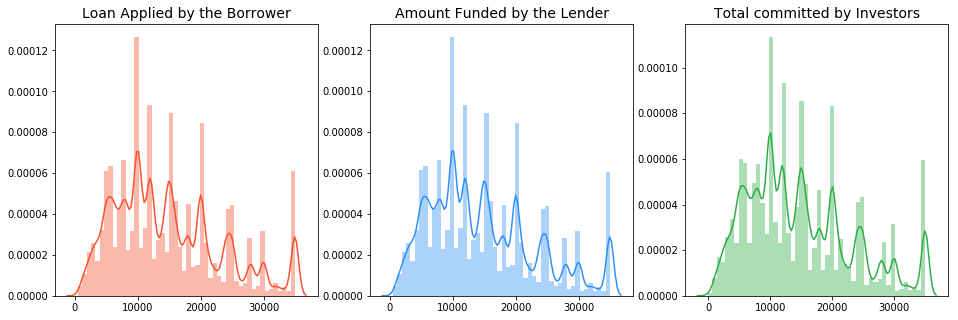

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for. Most of the loans issued were in the range of 10,000 to 20,000 USD. 

In [6]:
df['issue_d'].head()
# Lets' transform the issue dates by year.
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year

/Users/chaoma/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0, 0.5, 'Total loan amount issued')

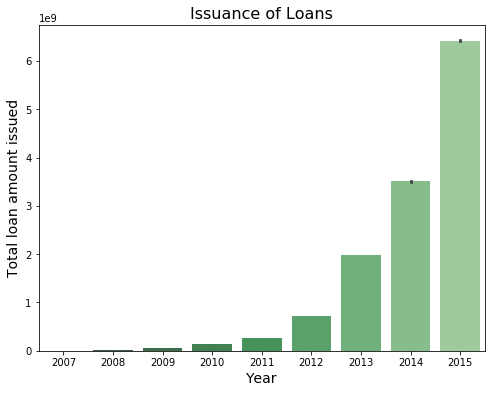

In [7]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(8,6))
sns.barplot('year', 'loan_amount', data=df, palette='Greens_d', estimator = sum)
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total loan amount issued', fontsize=14)

Loans issues was increasing year by year as the Lending Club exploded, most loans were issued in the year of 2015.

In [8]:
df["loan_status"].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [9]:
# Determining the loans that are bad from loan_status column
bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

/Users/chaoma/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



[Text(0, 0.5, '(%)')]

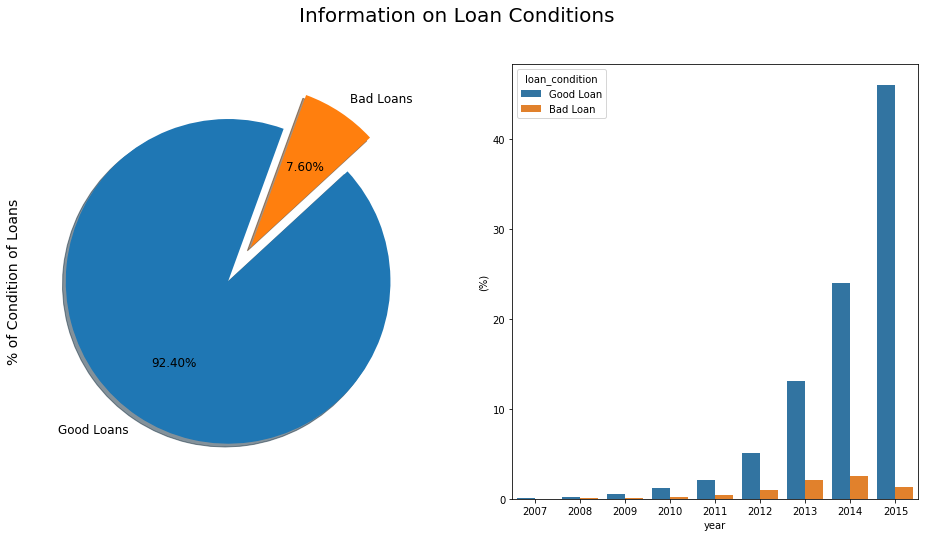

In [10]:
f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True,  
                                             labels=labels, fontsize=12, startangle=70)


ax[0].set_ylabel('% of Condition of Loans', fontsize=14)


sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)") #

Define the loan whose loan_condition is 'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'In Grace Period', 'Late (16-30 days)' or 'Late (31-120 days)' as 'Bad Loan'.

7.6% of total loans are bad loans but there are current loans which have the risk becoming bad loans. Loan business of Lending Club has been growing up rapidly since 2012 and the riskmanagement became omre effective after 2013.

In [11]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)

In [12]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amount']])

Text(0.5, 1.0, 'Loans issued by Region')

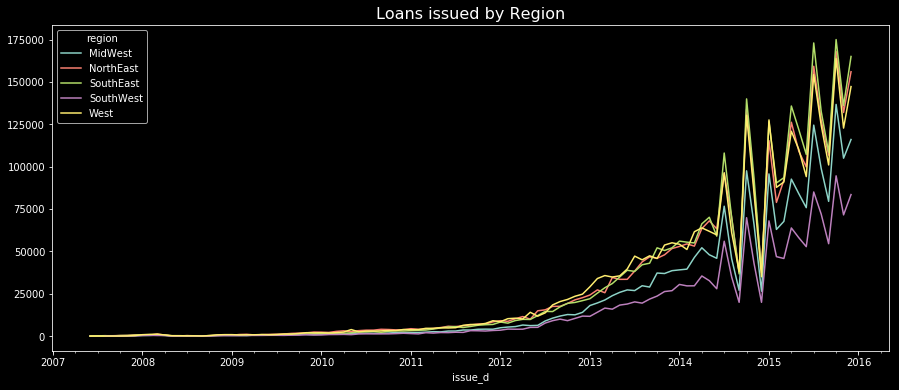

In [13]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

From the run chart of loans issued by region for the period from June, 2007 through December, 2015, we can find out that SouthEast , West and NorthEast regions had the highest amount lof loans issued.(Possible due to local economic.)

In [14]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

In [15]:
# We have 67429 loans categorized as bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['Does not meet the credit policy. Status:Charged Off'] = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,Does not meet the credit policy. Status:Charged Off,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,,
MidWest,7361,175,142,926,354,1820,10778
NorthEast,10671,263,190,1625,585,2799,16133
SouthEast,11094,297,184,1579,600,2925,16679
SouthWest,4774,166,79,708,273,1407,7407
West,11348,318,166,1415,545,2640,16432


In [16]:
charged_off = loan_status_cross['Charged Off'].values.tolist()
default = loan_status_cross['Default'].values.tolist()
not_meet_credit = loan_status_cross['Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = loan_status_cross['In Grace Period'].values.tolist()
short_pay = loan_status_cross['Late (16-30 days)'] .values.tolist()
long_pay = loan_status_cross['Late (31-120 days)'].values.tolist()



charged = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= charged_off,
    name='Charged Off',
    marker=dict(
        color='rgb(192, 148, 246)'
    ),
    text = '%'
)

defaults = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y=default,
    name='Defaults',
    marker=dict(
        color='rgb(176, 26, 26)'
    ),
    text = '%'
)

credit_policy = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= not_meet_credit,
    name='Does not meet Credit Policy',
    marker = dict(
        color='rgb(229, 121, 36)'
    ),
    text = '%'
)

grace = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= grace_period,
    name='Grace Period',
    marker = dict(
        color='rgb(147, 147, 147)'
    ),
    text = '%'
)

short_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= short_pay,
    name='Late Payment (16-30 days)', 
    marker = dict(
        color='rgb(246, 157, 135)'
    ),
    text = '%'
)

long_pays = go.Bar(
    x=['MidWest', 'NorthEast', 'SouthEast', 'SouthWest', 'West'],
    y= long_pay,
    name='Late Payment (31-120 days)',
    marker = dict(
        color = 'rgb(238, 76, 73)'
        ),
    text = '%'
)




data = [charged, defaults, credit_policy, grace, short_pays, long_pays]
layout = go.Layout(
    barmode='stack',
    title = '% of Bad Loan Status by Region',
    xaxis=dict(title='US Regions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

The regions of the West and SouthEast had a higher percentage in most of the b "bad" loan statuses.The NorthEast region had a higher percentage in Grace Period and Does not meet Credit Policy loan status.

In [17]:
# Average interest rates clients pay
df['interest_rate'].mean()

13.246739679476775

In [18]:
# Average annual income of clients
df['annual_income'].mean()

75027.58776076681

In [19]:
# Let's create categories for annual_income since most of the bad loans are located below 100k

df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [20]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)

/Users/chaoma/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



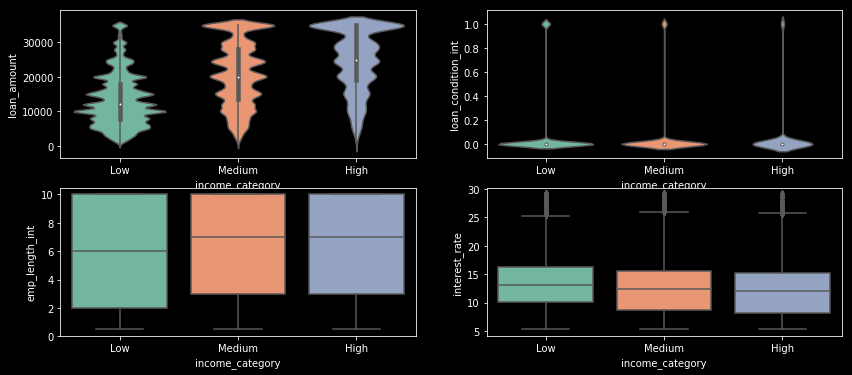

In [21]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="interest_rate", data=df, palette="Set2", ax=ax4)

Classify the borrowers by annual income as below:
Low income category: Borrowers that have an annual income lower or equal to 100,000 usd.
Medium income category: Borrowers that have an annual income higher than 100,000 usd but lower or equal to 200,000 usd.
High income category: Borrowers that have an annual income higher than 200,000 usd.
Borrowers having higher annual income took higher loan amounts than people with lower income and always had a average lower interest rate on their loans. <br>
Loans that were borrowed by the Low income category had a slightly higher change of becoming a bad loan.<br>
Borrowers with High and Medium annual incomes had a longer employment length than people with lower incomes.

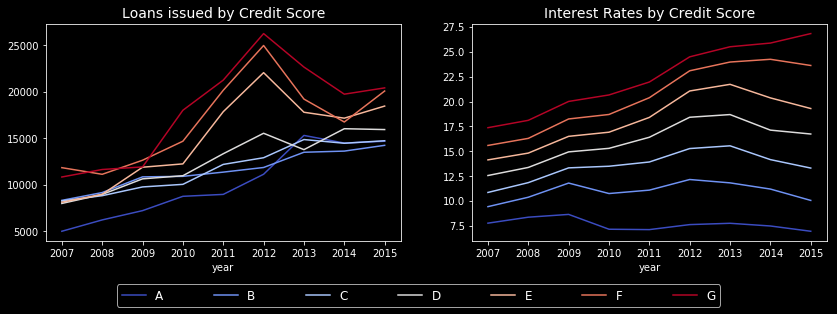

In [22]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

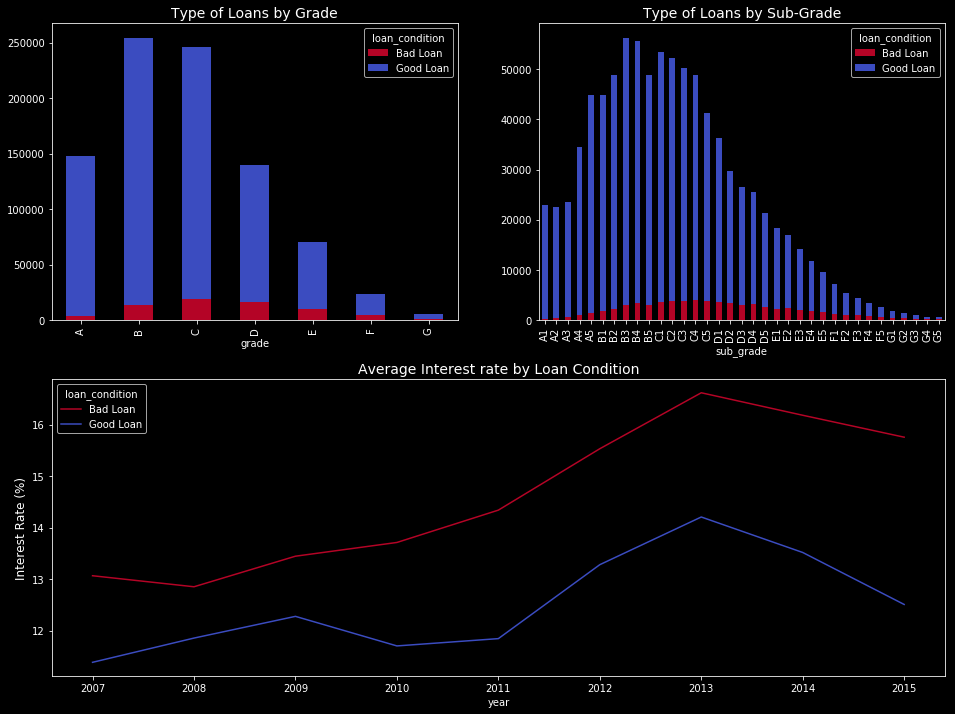

In [23]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['year', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

The borrowers with lower credit score or applied for a larger amount of money would receive a higher interest rate. The average interest rate of bad loans was higher than the one of the good loan, borrowers with lower credit grade would receive a higher rate which put pressure on them in return and the default became more likely.

In [24]:
# Just get me the numeric variables
numeric_variables = df.select_dtypes(exclude=["object"])

In [25]:
# We will use df_correlations dataframe to analyze our correlations.


df_correlations = df.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

Main factors that causes for a loan to be considered a "Bad Loan": low annual income, high debt to income, high interest rates, low grade

In [26]:
title = 'Bad Loans: Loan Statuses'

labels = bad_loan # All the elements that comprise a bad loan.

len(labels)
colors = ['rgba(236, 112, 99, 1)', 'rgba(235, 152, 78, 1)', 'rgba(52, 73, 94, 1)', 'rgba(128, 139, 150, 1)',
         'rgba(255, 87, 51, 1)', 'rgba(255, 195, 0, 1)']

mode_size = [8,8,8,8,8,8]

line_size = [2,2,2,2,2,2]

x_data = [
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()), 
    sorted(df['year'].unique().tolist()),
    sorted(df['year'].unique().tolist()),
]

# type of loans
charged_off = df['loan_amount'].loc[df['loan_status'] == 'Charged Off'].values.tolist()
defaults = df['loan_amount'].loc[df['loan_status'] == 'Default'].values.tolist()
not_credit_policy = df['loan_amount'].loc[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].values.tolist()
grace_period = df['loan_amount'].loc[df['loan_status'] == 'In Grace Period'].values.tolist()
short_late = df['loan_amount'].loc[df['loan_status'] == 'Late (16-30 days)'].values.tolist()
long_late = df['loan_amount'].loc[df['loan_status'] == 'Late (31-120 days)'].values.tolist()

y_data = [
    charged_off,
    defaults,
    not_credit_policy,
    grace_period,
    short_late,
    long_late,
]

p_charged_off = go.Scatter(
    x = x_data[0],
    y = y_data[0],
    name = 'A. Charged Off',
    line = dict(
        color = colors[0],
        width = 3,
        dash='dash')
)

p_defaults = go.Scatter(
    x = x_data[1],
    y = y_data[1],
    name = 'A. Defaults',
    line = dict(
        color = colors[1],
        width = 3,
        dash='dash')
)

p_credit_policy = go.Scatter(
    x = x_data[2],
    y = y_data[2],
    name = 'Not Meet C.P',
    line = dict(
        color = colors[2],
        width = 3,
        dash='dash')
)

p_graced = go.Scatter(
    x = x_data[3],
    y = y_data[3],
    name = 'A. Graced Period',
    line = dict(
        color = colors[3],
        width = 3,
        dash='dash')
)

p_short_late = go.Scatter(
    x = x_data[4],
    y = y_data[4],
    name = 'Late (16-30 days)',
    line = dict(
        color = colors[4],
        width = 3,
        dash='dash')
)

p_long_late = go.Scatter(
    x = x_data[5],
    y = y_data[5],
    name = 'Late (31-120 days)',
    line = dict(
        color = colors[5],
        width = 3,
        dash='dash')
)




data=[p_charged_off, p_defaults, p_credit_policy, p_graced, p_short_late, p_long_late]

layout = dict(title = 'Types of Bad Loans <br> (Amount Borrowed Throughout the Years)',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Issued'),
              )

fig = dict(data=data, layout=layout)

iplot(fig, filename='line-mode')

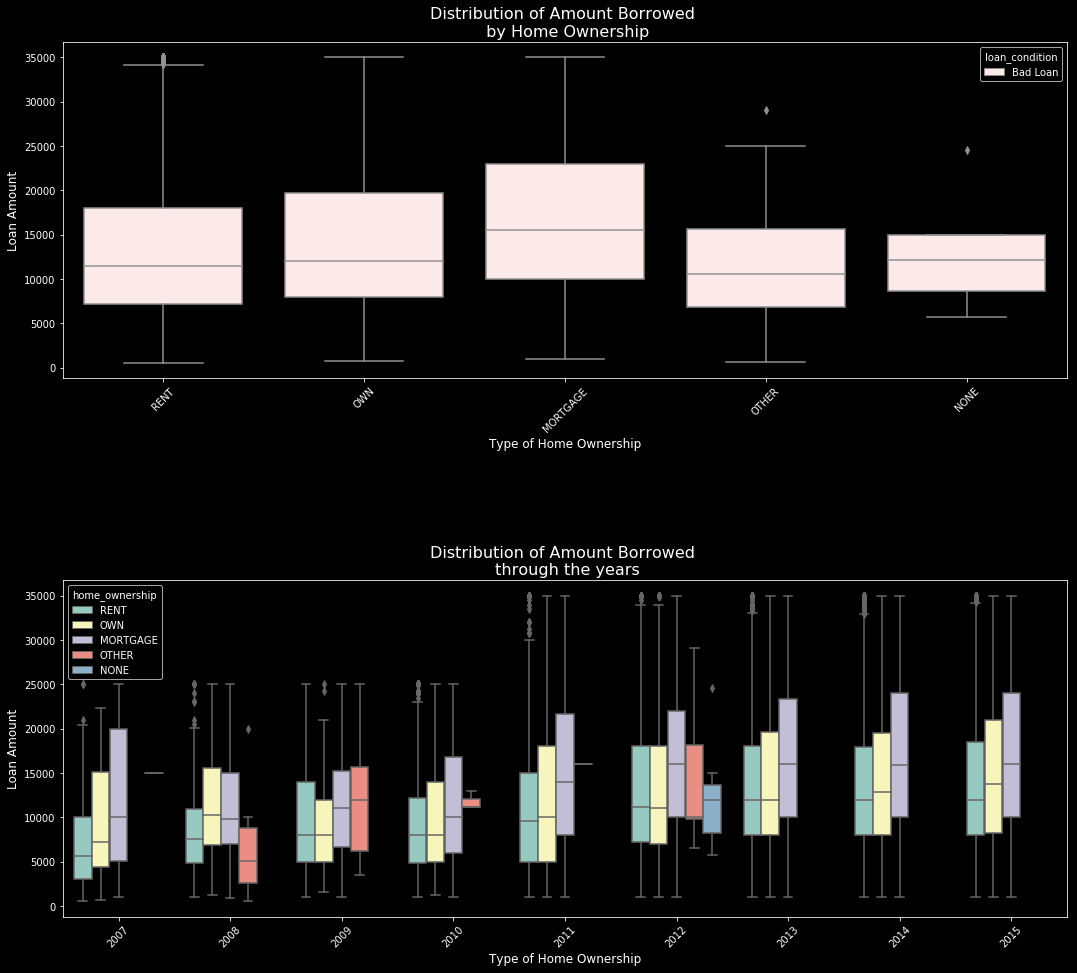

In [27]:
import seaborn as sns

plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

Mortgage was the variable from the home ownership column that used the highest amount borrowed within loans that were considered to be bad.

In [28]:
# Get the loan amount for loans that were defaulted by each region.
northe_defaults = df['loan_amount'].loc[(df['region'] == 'NorthEast') & (df['loan_status'] == 'Default')].values.tolist()
southw_defaults = df['loan_amount'].loc[(df['region'] == 'SouthWest') & (df['loan_status'] == 'Default')].values.tolist()
southe_defaults = df['loan_amount'].loc[(df['region'] == 'SouthEast') & (df['loan_status'] == 'Default')].values.tolist()
west_defaults = df['loan_amount'].loc[(df['region'] == 'West') & (df['loan_status'] == 'Default')].values.tolist()
midw_defaults = df['loan_amount'].loc[(df['region'] == 'MidWest') & (df['loan_status'] == 'Default')].values.tolist()

# Cumulative Values
y0_stck=northe_defaults
y1_stck=[y0+y1 for y0, y1 in zip(northe_defaults, southw_defaults)]
y2_stck=[y0+y1+y2 for y0, y1, y2 in zip(northe_defaults, southw_defaults, southe_defaults)]
y3_stck=[y0+y1+y2+y3 for y0, y1, y2, y3 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults)]
y4_stck=[y0+y1+y2+y3+y4 for y0, y1, y2, y3, y4 in zip(northe_defaults, southw_defaults, southe_defaults, west_defaults, midw_defaults)] 

# Make original values strings and add % for hover text
y0_txt=['$' + str(y0) for y0 in northe_defaults]
y1_txt=['$' + str(y1) for y1 in southw_defaults]
y2_txt=['$' + str(y2) for y2 in southe_defaults]
y3_txt=['$' + str(y3) for y3 in west_defaults]
y4_txt=['$'+ str(y4) for y4 in midw_defaults]

year = sorted(df["year"].unique().tolist())

NorthEast_defaults = go.Scatter(
    x= year,
    y= y0_stck,
    text=y0_txt,
    hoverinfo='x+text',
    name='NorthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(131, 90, 241)'),
    fill='tonexty'
)
SouthWest_defaults = go.Scatter(
    x=year,
    y=y1_stck,
    text=y1_txt,
    hoverinfo='x+text',
    name='SouthWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(255, 140, 0)'),
    fill='tonexty'
)

SouthEast_defaults = go.Scatter(
    x= year,
    y= y2_stck,
    text=y2_txt,
    hoverinfo='x+text',
    name='SouthEast',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 128, 128)'),
    fill='tonexty'
)

West_defaults = go.Scatter(
    x= year,
    y= y3_stck,
    text=y3_txt,
    hoverinfo='x+text',
    name='West',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(135, 206, 235)'),
    fill='tonexty'
)

MidWest_defaults = go.Scatter(
    x= year,
    y= y4_stck,
    text=y4_txt,
    hoverinfo='x+text',
    name='MidWest',
    mode= 'lines',
    line=dict(width=0.5,
             color='rgb(240, 230, 140)'),
    fill='tonexty'
    )


data = [NorthEast_defaults, SouthWest_defaults, SouthEast_defaults, West_defaults, MidWest_defaults]

layout = dict(title = 'Amount Defaulted by Region',
              xaxis = dict(title = 'Year'),
              yaxis = dict(title = 'Amount Defaulted')
             )

fig = dict(data=data, layout=layout)
              
iplot(fig, filename='basic-area-no-bound')

The Midwest and West regions had the most defaults.

In [29]:
df['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
df['interest_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
df.head()

,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_cu_tl,inq_last_12m,year,loan_condition,region,complete_date,emp_length_int,income_category,loan_condition_int,interest_payments
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,NaN,NaN,2011,Good Loan,SouthWest,2011-12-01,10.0,Low,0,Low
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,NaN,NaN,2011,Bad Loan,SouthEast,2011-12-01,0.5,Low,1,High
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,NaN,NaN,2011,Good Loan,MidWest,2011-12-01,10.0,Low,0,High
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,NaN,NaN,2011,Good Loan,West,2011-12-01,10.0,Low,0,High
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,NaN,NaN,2011,Good Loan,West,2011-12-01,1.0,Low,0,Low


In [30]:
df['term'].value_counts()

 36 months    621125
 60 months    266254
Name: term, dtype: int64

/Users/chaoma/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



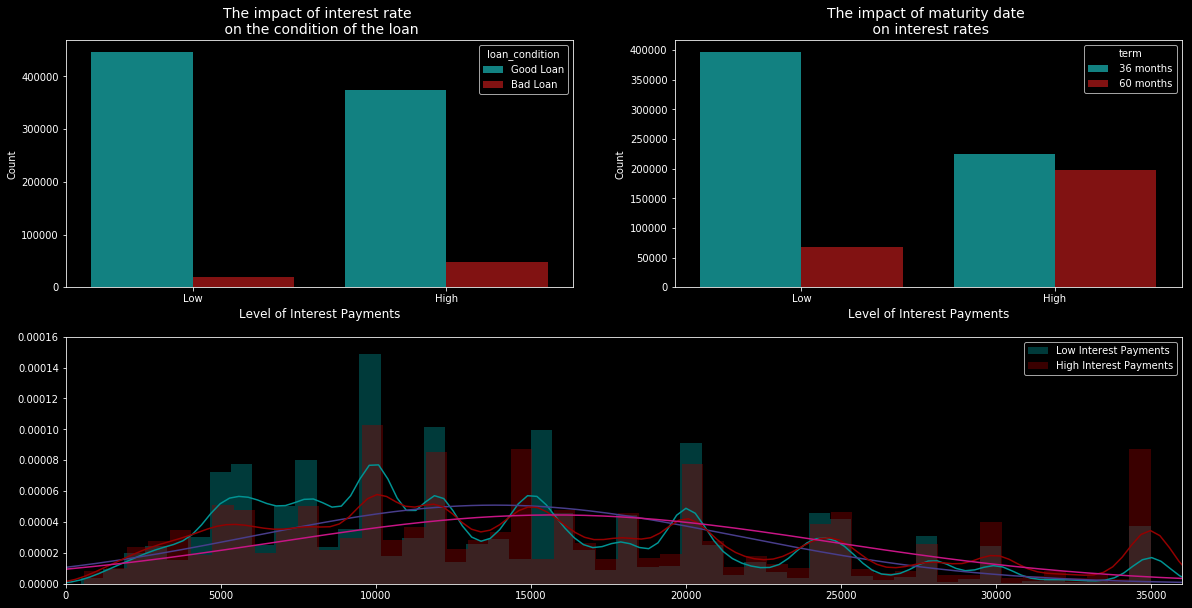

In [31]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


plt.subplot(212)
low = df['loan_amount'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amount'].loc[df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()


plt.show()

Loans that have a high interest rate(above 13.23%) are more likely to become a bad loan.<br>
Loans that have a longer maturity date (60 months) are more likely to be a bad loan.

In [32]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

The reasons for clients to apply for a loan contribute to a "higher" risk.
People that apply for educational and small business purposed tend to have a higher risk of being a bad loan. The reason that clients applied the most for a loan was to consolidate debt.Clients applied less for educational purposes for all three income categories.

In [33]:
# Average interest by income category and purposes 
# Which purpose carries a higher interest rate and does income category have an influence on risk?
# Is LendingClub deploying loan amount where there is a high risk (interest_rate)
# Remember we learned that interest_rates is a key metric in evaluating risk.


group_income_purpose = df.groupby(['income_category', 'purpose'], as_index=False).interest_rate.mean()
group_dti_purpose = df.groupby(['income_category', 'purpose'], as_index=False).loan_amount.mean()
loan_a = group_dti_purpose['loan_amount'].values



# High Car 10.32 15669
new_groupby = group_income_purpose.assign(total_loan_amount=loan_a)
sort_group_income_purpose = new_groupby.sort_values(by="income_category", ascending=True)

In [34]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_condition'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_condition"})

# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Good Loan"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_condition'] == "Bad Loan"].sort_values(by="income_category", ascending=True)
sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)
sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

,income_category,purpose,interest_rate,total_loan_amount,good_loans_count,bad_loans_count,total_loans_issued,bad/good ratio (%)
0,High,car,10.3261,15669.5,114,5,119,4.2
6,High,major_purchase,12.4163,22087.6,381,19,400,4.75
1,High,credit_card,10.6067,26007.8,3694,131,3825,3.42
2,High,debt_consolidation,12.4677,25287.2,7992,399,8391,4.76
4,High,home_improvement,12.2257,24097.8,2085,108,2193,4.92
5,High,house,16.4604,25617.7,122,2,124,1.61
10,High,renewable_energy,14.7209,20222.7,10,1,11,9.09
3,High,educational,11.42,11000,1,1,2,50
8,High,moving,15.1508,18868.6,94,7,101,6.93
9,High,other,14.3605,21433.8,831,52,883,5.89


In [35]:
final_df = final_df.sort_values(by="purpose", ascending=False)

In [36]:
# Work on a plot to explain better the correlations between the different columns in final_df dataframe.
# We will do a Subplot in Plotly with 

import plotly.plotly as py
import plotly.graph_objs as go

# Labels
purpose_labels = df['purpose'].unique()

# Average Interest Rate Dot Plots # 1st Subplot
high_income = final_df['interest_rate'].loc[final_df['income_category'] == 'High'].values.tolist()
medium_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Medium'].values.tolist()
low_income = final_df['interest_rate'].loc[final_df['income_category'] == 'Low'].values.tolist()

high_lst = ['%.2f' % val for val in high_income]
med_lst = ['%.2f' % val for val in medium_income]
low_lst = ['%.2f' % val for val in low_income]



trace1 = {"x": high_lst,
          "y": purpose_labels,
          "marker": {"color": "#0040FF", "size": 16},
          "mode": "markers",
          "name": "High Income",
          "type": "scatter"
}

trace2 = {"x": med_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE9A2E", "size": 16},
          "mode": "markers",
          "name": "Medium Income",
          "type": "scatter",
}

trace3 = {"x": low_lst,
          "y": purpose_labels,
          "marker": {"color": "#FE2E2E", "size": 16},
          "mode": "markers",
          "name": "Low Income",
          "type": "scatter",
}




data = [trace1, trace2, trace3]
layout = {"title": "Average Purpose Interest Rate <br> <i> by Income Category </i> ",
          "xaxis": {"title": "Average Interest Rate", },
          "yaxis": {"title": ""}}

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## 2. Build a model to predict whether a loan will default.

In [77]:
# Copy Dataframe
complete_df = df.copy()


# Handling Missing Numeric Values

# Transform Missing Values for numeric dataframe
# Nevertheless check what these variables mean tomorrow in the morning.
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    complete_df[col] = complete_df[col].fillna(0)
    


# # Get the mode of next payment date and last payment date and the last date credit amount was pulled   
complete_df["next_pymnt_d"] = complete_df.groupby("region")["next_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_pymnt_d"] = complete_df.groupby("region")["last_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_credit_pull_d"] = complete_df.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))
complete_df["earliest_cr_line"] = complete_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))

# # Get the mode on the number of accounts in which the client is delinquent
complete_df["pub_rec"] = complete_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# # Get the mean of the annual income depending in the region the client is located.
complete_df["annual_income"] = complete_df.groupby("region")["annual_income"].transform(lambda x: x.fillna(x.mean()))

# Get the mode of the  total number of credit lines the borrower has 
complete_df["total_acc"] = complete_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Mode of credit delinquencies in the past two years.
complete_df["delinq_2yrs"] = complete_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))


In [78]:
complete_df.drop(['issue_d', 'income_category', 'region', 'year', 'emp_length', 'loan_condition',
                 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 
                 'verification_status_joint', 'emp_length_int', 'total_rec_prncp', 'funded_amount', 'investor_funds', 
                 'sub_grade', 'complete_date', 'loan_status', 'interest_payments', 
                 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
               'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
               'collection_recovery_fee', 'last_pymnt_amnt',
               'collections_12_mths_ex_med', 'mths_since_last_major_derog',
               'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
               'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
               'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
               'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
               'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'], axis=1, inplace=True)

In [79]:
complete_df.columns

Index(['loan_amount', 'term', 'interest_rate', 'installment', 'grade',
       'home_ownership', 'annual_income', 'verification_status', 'pymnt_plan',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'loan_condition_int'],
      dtype='object')

In [80]:
complete_df.isnull().sum().max()

0

In [81]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression


len(complete_df['loan_condition_int'])
# Loan Ratios (Imbalanced classes)
complete_df['loan_condition_int'].value_counts()/len(complete_df['loan_condition_int']) * 100

0    92.40133
1     7.59867
Name: loan_condition_int, dtype: float64

In [82]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(complete_df, complete_df["loan_condition_int"]):
    stratified_train = complete_df.loc[train_set]
    stratified_test = complete_df.loc[test_set]
    
print('Train set ratio \n', stratified_train["loan_condition_int"].value_counts()/len(df))
print('Test set ratio \n', stratified_test["loan_condition_int"].value_counts()/len(df))

Train set ratio 
 0    0.739211
1    0.060789
Name: loan_condition_int, dtype: float64
Test set ratio 
 0    0.184803
1    0.015198
Name: loan_condition_int, dtype: float64


In [83]:
train_df = stratified_train
test_df = stratified_test


# Let's Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


# Train set (Normal training dataset)
X_train = train_df.drop('loan_condition_int', axis=1)
y_train = train_df['loan_condition_int']


# Test Dataset
X_test = test_df.drop('loan_condition_int', axis=1)
y_test = test_df['loan_condition_int']

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709903 entries, 0 to 709902
Data columns (total 21 columns):
loan_amount               709903 non-null float64
term                      709903 non-null object
interest_rate             709903 non-null float64
installment               709903 non-null float64
grade                     709903 non-null object
home_ownership            709903 non-null object
annual_income             709903 non-null float64
verification_status       709903 non-null object
pymnt_plan                709903 non-null object
purpose                   709903 non-null object
addr_state                709903 non-null object
dti                       709903 non-null float64
delinq_2yrs               709903 non-null float64
inq_last_6mths            709903 non-null float64
mths_since_last_delinq    709903 non-null float64
mths_since_last_record    709903 non-null float64
open_acc                  709903 non-null float64
pub_rec                   709903 non-null floa

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [88]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

# Columns to delete or fix: earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d, verification_status_joint

numeric = X_train.select_dtypes(exclude=["object"])
categorical = X_train.select_dtypes(["object"])

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric.columns.tolist())),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical.columns.tolist())), # We will have to write the categorical columns manually and see if it works.
    ('encoder', CategoricalEncoder(encoding="onehot-dense")),
])

# Combine both Pipelines into one array
combined_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

X_train_tran = combined_pipeline.fit_transform(X_train)
X_test_tran = combined_pipeline.fit_transform(X_test)

In [89]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_tran, y_train)

/Users/chaoma/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [90]:
from sklearn.metrics import accuracy_score

normal_ypred = log_reg.predict(X_test_tran)
print(accuracy_score(y_test, normal_ypred))

0.9239953571187091


In [91]:
import xgboost as xgb

In [94]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=10)
xgb_model.fit(X_train_tran, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [95]:
y_pred = xgb_model.predict(X_test_tran)
accuracy_score(y_test, y_pred)

0.9240122608127296

## 3. Select metrics for monitoring current loan status --- the risk of defaulting in the future.

In [113]:
monitor_df = df.copy()


# Handling Missing Numeric Values

# Transform Missing Values for numeric dataframe
# Nevertheless check what these variables mean tomorrow in the morning.
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    monitor_df[col] = monitor_df[col].fillna(0)
    


# # Get the mode of next payment date and last payment date and the last date credit amount was pulled   
monitor_df["next_pymnt_d"] = monitor_df.groupby("region")["next_pymnt_d"].transform(lambda x: x.fillna(x.mode))
monitor_df["last_pymnt_d"] = monitor_df.groupby("region")["last_pymnt_d"].transform(lambda x: x.fillna(x.mode))
monitor_df["last_credit_pull_d"] = monitor_df.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))
monitor_df["earliest_cr_line"] = monitor_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))

# # Get the mode on the number of accounts in which the client is delinquent
monitor_df["pub_rec"] = monitor_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# # Get the mean of the annual income depending in the region the client is located.
monitor_df["annual_income"] = monitor_df.groupby("region")["annual_income"].transform(lambda x: x.fillna(x.mean()))

# Get the mode of the  total number of credit lines the borrower has 
monitor_df["total_acc"] = monitor_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Mode of credit delinquencies in the past two years.
monitor_df["delinq_2yrs"] = monitor_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [125]:
monitor_df = df.copy()

In [126]:
data = monitor_df[monitor_df.loan_status != 'Current']

In [134]:
selected_column = data.drop(['issue_d', 'income_category', 'region', 'year', 'emp_length', 'loan_condition','loan_condition_int',
                 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 
                 'verification_status_joint', 'emp_length_int', 'total_rec_prncp', 'funded_amount', 'investor_funds', 
                 'sub_grade', 'complete_date', 'loan_status', 'interest_payments', 
                 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
               'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
               'collection_recovery_fee', 'last_pymnt_amnt',
               'collections_12_mths_ex_med', 'mths_since_last_major_derog',
               'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
               'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
               'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
               'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
               'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'], axis = 1)

In [135]:
X = pd.get_dummies(selected_column)

In [136]:
y = data['loan_condition_int']

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [138]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=10)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [139]:
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7681792717086835

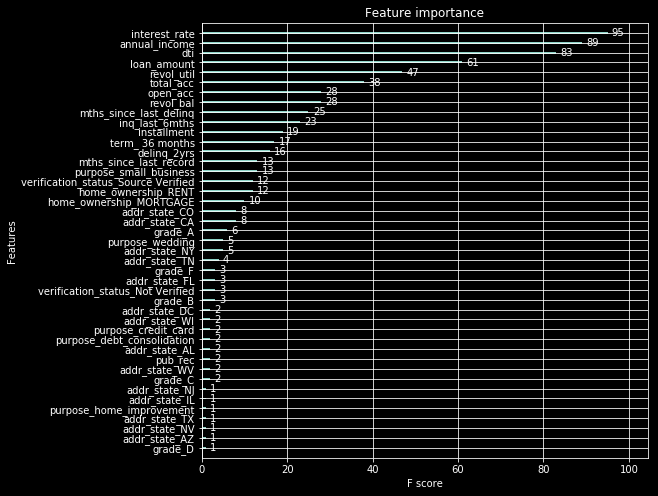

In [140]:
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(xgb_model, ax=ax)

### Final metrics selected for monitoring the risk of a loan defaulted in the future.
dti(debt to income), revol_util(The borrower’s revolving line utilization rate (the amount of the credit line used relative to total credit available).), annual_inc,(annual income) ， rov_bal(The borrower’s revolving balance (amount unpaid at the end of the credit card billing cycle).), total_acc(The total number of credit lines currently in the borrower's credit file), mths_since_last_delinq (The number of months since the borrower's last delinquency.), inq_last_6mths(The number of inquiries in past 6 months (excluding auto and mortgage inquiries)).